In [2]:
import requests
from bs4 import BeautifulSoup
import functools
from function_pipes import pipe
import numpy as np
import networkx as nx
import copy
import matplotlib
from pprint import pprint
import pandas as pd
import collections

Grabbing Webpage

In [3]:
url = "https://masteringruneterra.com/mu-table/"
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

Doing finding and stuff

In [4]:
headers = soup.select("div.grid-item:not(.versus-cell)")
headers = map(lambda x: x.text.strip(), headers)
decks = list(headers)[1:16]
print(len(decks))
print(decks)

15
['Elder Dragon Galio Morgana (DE/RU)', 'Mordekaiser Morgana (DE/SI)', 'Elder Dragon Mordekaiser Viego (RU/SI)', 'Annie Jhin (NX/RU)', 'Gwen Zed (IO/SI)', 'Teemo Yuumi (BC/PZ)', 'Elder Dragon Volibear (FR/RU)', "Pyke Rek'Sai (BW/SH)", 'Elder Dragon Norra (BC/RU)', 'Lissandra Volibear (FR/SI)', 'Karma Sett (IO/PZ)', 'Elder Dragon Shyvana (DE/RU)', 'Karma Sett (FR/IO)', 'Caitlyn Teemo (FR/PZ)', 'Ashe LeBlanc (FR/NX)']


In [5]:
cells = soup.select(".versus-cell > div")
rawText = map(lambda x: x.text.strip(), cells)
def getWinRateAndGames(text):
    winRate, games = text.split("\n");
    #handing winrate
    winRate = winRate[:-1]#dropping %
    winRate = float(winRate)
    winRate = winRate / 100
    winRate = round(winRate, 4)
    
    #handling games
    games = games.split(" ")[1]
    games = int(games)
    return {"winRate": winRate, "gamesPlayed": games}
matchUps = list(map(getWinRateAndGames, rawText))
matchUps[0:10]



[{'winRate': 0.4035, 'gamesPlayed': 9234},
 {'winRate': 0.4399, 'gamesPlayed': 7851},
 {'winRate': 0.5352, 'gamesPlayed': 5583},
 {'winRate': 0.4967, 'gamesPlayed': 4667},
 {'winRate': 0.548, 'gamesPlayed': 4907},
 {'winRate': 0.6747, 'gamesPlayed': 3053},
 {'winRate': 0.4666, 'gamesPlayed': 3339},
 {'winRate': 0.7129, 'gamesPlayed': 3337},
 {'winRate': 0.3989, 'gamesPlayed': 3116},
 {'winRate': 0.6419, 'gamesPlayed': 2907}]

Converting to a table

In [6]:
table = {key: {} for key in decks}
muIndex = 0
for rawIndex in range(len(decks) * len(decks)):
    i = rawIndex // 15
    j = rawIndex % 15
    deck1 = decks[i]
    deck2 = decks[j]
    if i == j: #diagonal on the match up, the deck is playing itself
        table[deck1][deck2] = {"winRate": 0.5, "gamesPlayed": 10000}
        continue
    mu = matchUps[muIndex]
    muIndex += 1
    table[deck1][deck2] = {"winRate": mu["winRate"], "gamesPlayed": mu["gamesPlayed"]}
print(table)

{'Elder Dragon Galio Morgana (DE/RU)': {'Elder Dragon Galio Morgana (DE/RU)': {'winRate': 0.5, 'gamesPlayed': 10000}, 'Mordekaiser Morgana (DE/SI)': {'winRate': 0.4035, 'gamesPlayed': 9234}, 'Elder Dragon Mordekaiser Viego (RU/SI)': {'winRate': 0.4399, 'gamesPlayed': 7851}, 'Annie Jhin (NX/RU)': {'winRate': 0.5352, 'gamesPlayed': 5583}, 'Gwen Zed (IO/SI)': {'winRate': 0.4967, 'gamesPlayed': 4667}, 'Teemo Yuumi (BC/PZ)': {'winRate': 0.548, 'gamesPlayed': 4907}, 'Elder Dragon Volibear (FR/RU)': {'winRate': 0.6747, 'gamesPlayed': 3053}, "Pyke Rek'Sai (BW/SH)": {'winRate': 0.4666, 'gamesPlayed': 3339}, 'Elder Dragon Norra (BC/RU)': {'winRate': 0.7129, 'gamesPlayed': 3337}, 'Lissandra Volibear (FR/SI)': {'winRate': 0.3989, 'gamesPlayed': 3116}, 'Karma Sett (IO/PZ)': {'winRate': 0.6419, 'gamesPlayed': 2907}, 'Elder Dragon Shyvana (DE/RU)': {'winRate': 0.6519, 'gamesPlayed': 2614}, 'Karma Sett (FR/IO)': {'winRate': 0.7121, 'gamesPlayed': 2397}, 'Caitlyn Teemo (FR/PZ)': {'winRate': 0.7551, 'ga

Creating Network from it


In [7]:
#changing it so the weights are the winrate

def getWinRate(item):
    return item["winRate"]

def onlyGoodMUs(item):
    winRate = getWinRate(item)
    if winRate > 0.55:
        return winRate
    return False

def convertGraph(table, converter):
    clonedTable = copy.deepcopy(table)
    for key, value in clonedTable.items():
        newDict = {}
        for key2, value2 in value.items():
            newValue = converter(value2)
            if newValue:
                newDict[key2] = {"weight": newValue}
        clonedTable[key] = newDict
    return clonedTable
winRateTable = convertGraph(table, getWinRate)
goodWinRates = convertGraph(table, onlyGoodMUs)
pprint(winRateTable)

{'Annie Jhin (NX/RU)': {'Annie Jhin (NX/RU)': {'weight': 0.5},
                        'Ashe LeBlanc (FR/NX)': {'weight': 0.6622},
                        'Caitlyn Teemo (FR/PZ)': {'weight': 0.7282},
                        'Elder Dragon Galio Morgana (DE/RU)': {'weight': 0.4646},
                        'Elder Dragon Mordekaiser Viego (RU/SI)': {'weight': 0.6356},
                        'Elder Dragon Norra (BC/RU)': {'weight': 0.3929},
                        'Elder Dragon Shyvana (DE/RU)': {'weight': 0.5539},
                        'Elder Dragon Volibear (FR/RU)': {'weight': 0.8037},
                        'Gwen Zed (IO/SI)': {'weight': 0.5981},
                        'Karma Sett (FR/IO)': {'weight': 0.7727},
                        'Karma Sett (IO/PZ)': {'weight': 0.4343},
                        'Lissandra Volibear (FR/SI)': {'weight': 0.6648},
                        'Mordekaiser Morgana (DE/SI)': {'weight': 0.5225},
                        "Pyke Rek'Sai (BW/SH)": {'weight': 0

In [8]:
G = nx.from_dict_of_dicts(winRateTable)
G

Writing to file

In [9]:
nx.write_graphml(G, "data/mu.graphml")

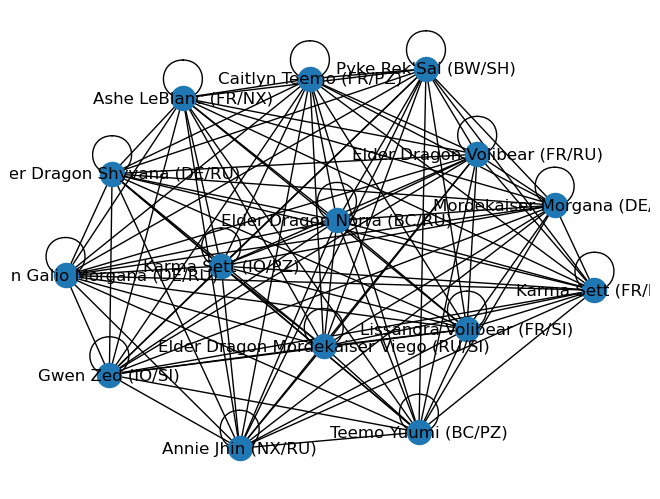

In [10]:
nx.draw(G, with_labels=True)

Graphing only good winrates

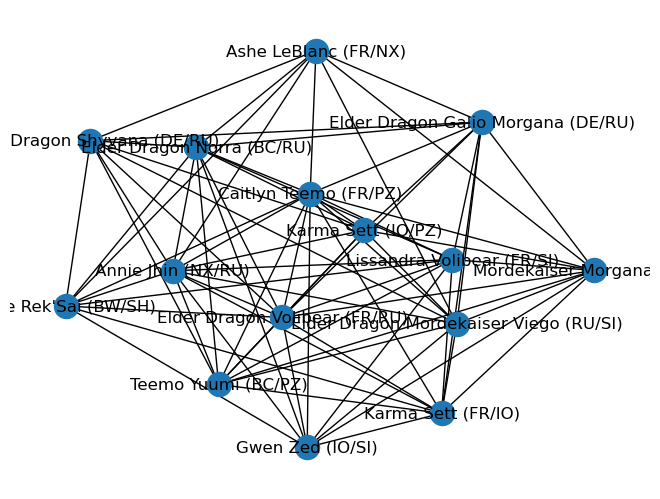

In [11]:
goodG = nx.from_dict_of_dicts(goodWinRates)
nx.draw(goodG, with_labels=True)

Translating to pandas

In [12]:
def toPandasDict(table, getter):
    newTable = {}
    for key, value in table.items():
        otherDecks = value.values()  
        newValues = pipe(map(getter, otherDecks), list)
        newTable[key] = newValues
    newTable["decks"] = decks
    return newTable
def toDf(table, getter):
    translatedTable = toPandasDict(table, getter)
    df = pd.DataFrame.from_dict(translatedTable).set_index("decks").T
    return df
    
winDF = toDf(table, getWinRate)
playRateDF = toDf(table, lambda x: x["gamesPlayed"])
display(winDF)
display(playRateDF)


decks,Elder Dragon Galio Morgana (DE/RU),Mordekaiser Morgana (DE/SI),Elder Dragon Mordekaiser Viego (RU/SI),Annie Jhin (NX/RU),Gwen Zed (IO/SI),Teemo Yuumi (BC/PZ),Elder Dragon Volibear (FR/RU),Pyke Rek'Sai (BW/SH),Elder Dragon Norra (BC/RU),Lissandra Volibear (FR/SI),Karma Sett (IO/PZ),Elder Dragon Shyvana (DE/RU),Karma Sett (FR/IO),Caitlyn Teemo (FR/PZ),Ashe LeBlanc (FR/NX)
Elder Dragon Galio Morgana (DE/RU),0.5000,0.4035,0.4399,0.5352,0.4967,0.5480,0.6747,0.4666,0.7129,0.3989,0.6419,0.6519,0.7121,0.7551,0.6663
Mordekaiser Morgana (DE/SI),0.5965,0.5000,0.3786,0.4775,0.5521,0.3965,0.4411,0.5303,0.4548,0.3811,0.3749,0.5274,0.4084,0.4383,0.6825
Elder Dragon Mordekaiser Viego (RU/SI),0.5601,0.6214,0.5000,0.3641,0.3628,0.1913,0.5057,0.5215,0.4739,0.5468,0.4362,0.6020,0.3871,0.3128,0.6216
Annie Jhin (NX/RU),0.4646,0.5225,0.6356,0.5000,0.5981,0.4345,0.8037,0.5780,0.3929,0.6648,0.4343,0.5539,0.7727,0.7282,0.6622
Gwen Zed (IO/SI),0.5033,0.4479,0.6372,0.4019,0.5000,0.5185,0.7620,0.6432,0.3165,0.6835,0.4504,0.5420,0.7374,0.5881,0.5128
Teemo Yuumi (BC/PZ),0.4520,0.6035,0.8087,0.5655,0.4808,0.5000,0.7811,0.5450,0.4338,0.6297,0.4024,0.5698,0.6587,0.7399,0.4873
Elder Dragon Volibear (FR/RU),0.3253,0.5589,0.4943,0.1963,0.2380,0.2189,0.5000,0.3137,0.5796,0.5714,0.5819,0.6078,0.4104,0.3757,0.4893
Pyke Rek'Sai (BW/SH),0.5334,0.4697,0.4785,0.4220,0.3568,0.4550,0.6863,0.5000,0.4260,0.7410,0.5075,0.5671,0.6534,0.6211,0.4415
Elder Dragon Norra (BC/RU),0.2871,0.5452,0.5261,0.6071,0.6835,0.5652,0.4204,0.5741,0.5000,0.3858,0.5785,0.3459,0.5036,0.6414,0.6368
Lissandra Volibear (FR/SI),0.6011,0.6189,0.4526,0.3352,0.3165,0.3703,0.4286,0.2590,0.6142,0.5000,0.5072,0.5322,0.3243,0.4178,0.4710


decks,Elder Dragon Galio Morgana (DE/RU),Mordekaiser Morgana (DE/SI),Elder Dragon Mordekaiser Viego (RU/SI),Annie Jhin (NX/RU),Gwen Zed (IO/SI),Teemo Yuumi (BC/PZ),Elder Dragon Volibear (FR/RU),Pyke Rek'Sai (BW/SH),Elder Dragon Norra (BC/RU),Lissandra Volibear (FR/SI),Karma Sett (IO/PZ),Elder Dragon Shyvana (DE/RU),Karma Sett (FR/IO),Caitlyn Teemo (FR/PZ),Ashe LeBlanc (FR/NX)
Elder Dragon Galio Morgana (DE/RU),10000,9234,7851,5583,4667,4907,3053,3339,3337,3116,2907,2614,2397,2336,2074
Mordekaiser Morgana (DE/SI),9234,10000,4514,3242,2583,2802,1834,1895,2036,1695,1619,1515,1457,1280,1260
Elder Dragon Mordekaiser Viego (RU/SI),7851,4514,10000,2958,2183,2164,1916,1722,1684,1582,1394,1422,1320,1266,1184
Annie Jhin (NX/RU),5583,3242,2958,10000,1545,1634,1192,1237,1163,1080,1027,946,871,813,746
Gwen Zed (IO/SI),4667,2583,2183,1545,10000,1352,958,1093,1011,951,797,810,712,721,704
Teemo Yuumi (BC/PZ),4907,2802,2164,1634,1352,10000,859,855,959,821,850,774,715,692,591
Elder Dragon Volibear (FR/RU),3053,1834,1916,1192,958,859,10000,816,754,658,562,668,558,543,515
Pyke Rek'Sai (BW/SH),3339,1895,1722,1237,1093,855,816,10000,763,637,668,589,479,578,496
Elder Dragon Norra (BC/RU),3337,2036,1684,1163,1011,959,754,763,10000,648,669,529,556,474,446
Lissandra Volibear (FR/SI),3116,1695,1582,1080,951,821,658,637,648,10000,554,575,518,438,482


Getting best preforming decks

In [15]:
def getMetaCounters(winDF: pd.DataFrame, numMetaDecks=15, numDecksToReturn = 5):
    
    # get the expected winrate against each n meta decks
    metaDecks = winDF.iloc[:, :numMetaDecks + 1] 
   
    # get the expected winrate by averaging that
    expectedWinRates = metaDecks.mean(axis=1)
    
    # return the highest n ones
    sortedDecks = expectedWinRates.sort_values(ascending=False)[0:numDecksToReturn + 1]
    
    #add the winrates against each of the metadecks
    df = pd.DataFrame(sortedDecks, columns=["expected winrate"])
    
    matchUps = winDF.loc[sortedDecks.keys()]
    df = df.join(matchUps) #adding winrates against each meta deck
    return df

getMetaCounters(winDF)

,expected winrate,Elder Dragon Galio Morgana (DE/RU),Mordekaiser Morgana (DE/SI),Elder Dragon Mordekaiser Viego (RU/SI),Annie Jhin (NX/RU),Gwen Zed (IO/SI),Teemo Yuumi (BC/PZ),Elder Dragon Volibear (FR/RU),Pyke Rek'Sai (BW/SH),Elder Dragon Norra (BC/RU),Lissandra Volibear (FR/SI),Karma Sett (IO/PZ),Elder Dragon Shyvana (DE/RU),Karma Sett (FR/IO),Caitlyn Teemo (FR/PZ),Ashe LeBlanc (FR/NX)
Annie Jhin (NX/RU),0.583067,0.4646,0.5225,0.6356,0.5000,0.5981,0.4345,0.8037,0.5780,0.3929,0.6648,0.4343,0.5539,0.7727,0.7282,0.6622
Teemo Yuumi (BC/PZ),0.577213,0.4520,0.6035,0.8087,0.5655,0.4808,0.5000,0.7811,0.5450,0.4338,0.6297,0.4024,0.5698,0.6587,0.7399,0.4873
Elder Dragon Galio Morgana (DE/RU),0.573580,0.5000,0.4035,0.4399,0.5352,0.4967,0.5480,0.6747,0.4666,0.7129,0.3989,0.6419,0.6519,0.7121,0.7551,0.6663
Gwen Zed (IO/SI),0.549647,0.5033,0.4479,0.6372,0.4019,0.5000,0.5185,0.7620,0.6432,0.3165,0.6835,0.4504,0.5420,0.7374,0.5881,0.5128
Pyke Rek'Sai (BW/SH),0.523953,0.5334,0.4697,0.4785,0.4220,0.3568,0.4550,0.6863,0.5000,0.4260,0.7410,0.5075,0.5671,0.6534,0.6211,0.4415
Elder Dragon Norra (BC/RU),0.520047,0.2871,0.5452,0.5261,0.6071,0.6835,0.5652,0.4204,0.5741,0.5000,0.3858,0.5785,0.3459,0.5036,0.6414,0.6368
